# Autoencoder Models Performance Analysis

## Notebook Overview 
The purpose of this notebook is to analyze the performance of various Autoencoder architectures through training and evaluation (T&E hereafter) on the CityLearn Challenge 2023 dataset.

### Imports
This section imports essential libraries used throughout the notebook and adds the 'src' directory to the system path to allow importing modules from the source folder. 

In [1]:
import pandas as pd
import numpy as np
import sys
import os
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import AutoencoderBasic as aeb
from dl_models import AutoencoderAdvanced as aea
from dl_models import AutoencoderRefined as aer
from dl_models import AutoencoderKfold as aek
from utils import plots as plt

## Introductory test
As an initial approach to the model, this T&E will be performed on the samples from Building 1 of the dataset, targeting three features: cooling demand, carbon intensity and solar generation.

In this case, the baseline Autoencoder is adopted, a simple architecture composed of one encoder layer and one decoder layer, each with 64 neurons and linear activation functions.
A plot is generated for each target, showing the different normalized errors, allowing comparison with the normalized performance of the other models used in the project.

In [2]:
# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Concatenate multiple datasets along the columns to create a single dataset.
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)

In [3]:
# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

In [4]:
real_1, pred_1 = aeb.Autoencoder(dataframe=df, features=features, epochs = 1000, batch_size=256)

Epoch 1/1000
2/2 [==============================] - 1s 4ms/step - loss: 0.1348 - mean_absolute_error: 0.3242
Epoch 2/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.1240 - mean_absolute_error: 0.3122
Epoch 3/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.1139 - mean_absolute_error: 0.2998
Epoch 4/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.1039 - mean_absolute_error: 0.2863
Epoch 5/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0938 - mean_absolute_error: 0.2713
Epoch 6/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0839 - mean_absolute_error: 0.2551
Epoch 7/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0742 - mean_absolute_error: 0.2377
Epoch 8/1000
2/2 [==============================] - 0s 3ms/step - loss: 0.0654 - mean_absolute_error: 0.2199
Epoch 9/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0580 - mean_absolute_error: 0.2026
Epoch 10/1000
2/2 [

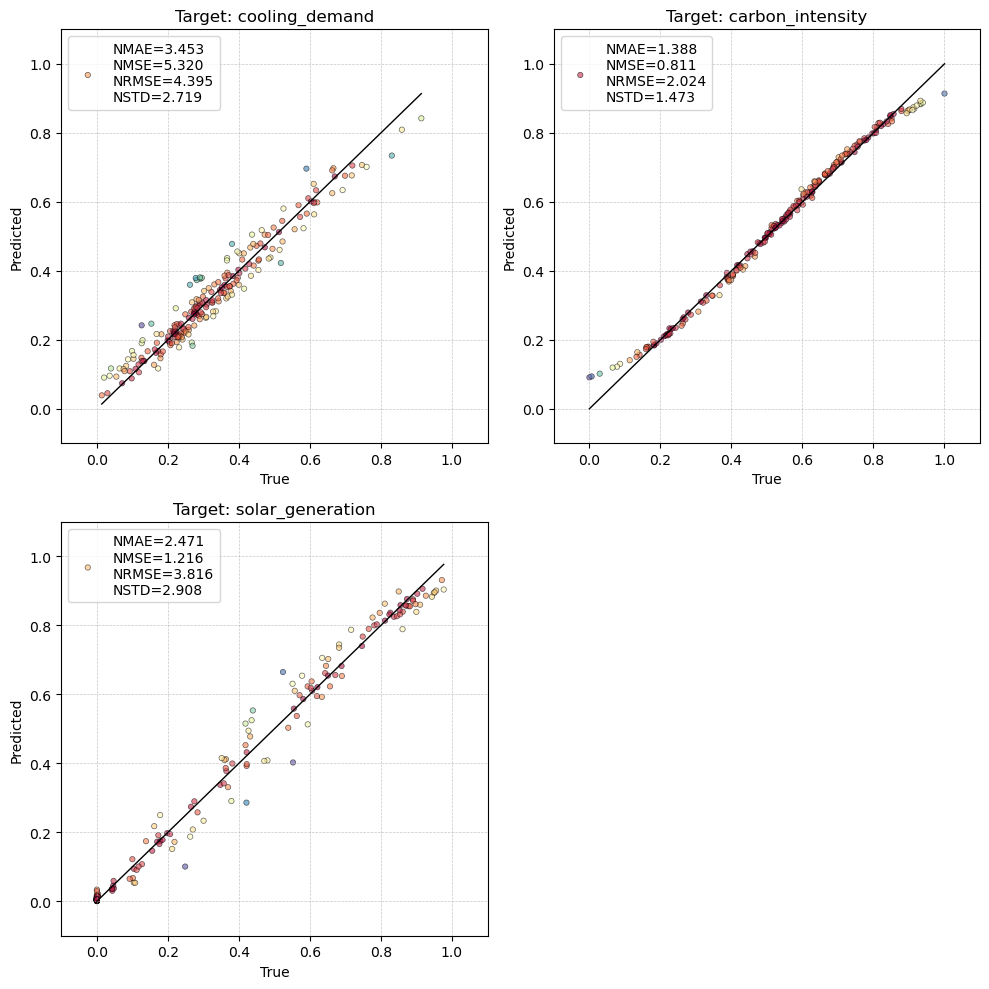

In [5]:
plt.plot_targets(real_1, pred_1, targets, features, percent=True)

## Cross-Building test
The targets and the model remain unchanged. For this phase, we will use 100% of the data from Building 1 for training, while the remaining two buildings, being triplets with the first, will be used to evaluate the model's performance.

In [6]:
## Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Concatenate train and test data
train_df = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)

# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

# Combine the building data and the repeated external data horizontally, preparing the final test dataset
test_df = pd.concat([building_2_3_data, external_data_repeated], axis=1)

In [7]:
real_2, pred_2 = aeb.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, batch_size=256)

Epoch 1/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.1402 - mean_absolute_error: 0.3274
Epoch 2/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.1235 - mean_absolute_error: 0.3074
Epoch 3/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.1093 - mean_absolute_error: 0.2895
Epoch 4/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.0958 - mean_absolute_error: 0.2706
Epoch 5/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0829 - mean_absolute_error: 0.2500
Epoch 6/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0709 - mean_absolute_error: 0.2278
Epoch 7/3000
3/3 [==============================] - 0s 4ms/step - loss: 0.0609 - mean_absolute_error: 0.2057
Epoch 8/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0533 - mean_absolute_error: 0.1856
Epoch 9/3000
3/3 [==============================] - 0s 3ms/step - loss: 0.0480 - mean_absolute_error: 0.1695
Epoch 10/3000
3/3 [

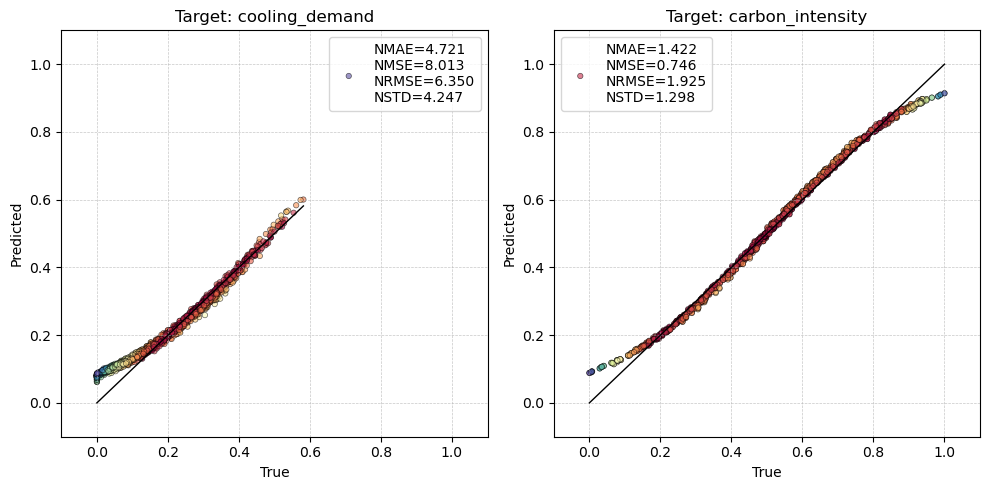

In [8]:
plt.plot_targets(real_2, pred_2, targets[:2], features, percent=True)

## Enhanced Architectures test
In this section, we evaluate the previous tests on a more advanced autoencoder architecture, designed to improve the model's ability to learn from complex data and potentially reduce errors. This architecture introduces deeper layers, different activation functions, and other optimizations aimed at enhancing performance over the previous model.

### Adding Hidden Layers

Now, two hidden layers are added to both the encoder and decoder in order to enhance the model’s representation capacity.

Encoder:
- Dense layer with 128 units and linear activation;
- Dense layer with 64 units and linear activation;
- Dense layer with 32 units and linear activation.

Bottleneck (latent) layer with n units and linear activation.

Decoder:
- Dense layer with 32 units and linear activation;
- Dense layer with 64 units and linear activation;
- Dense layer with 128 units and linear activation.

Output layer with a sigmoid activation to reconstruct the input.

This structure is designed to capture more complex relationships within the data while maintaining symmetry between the encoding and decoding paths.

In [9]:
real_3, pred_3 = aea.Autoencoder(dataframe=df, features=features, epochs = 1000, batch_size = 64)

Epoch 1/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0769 - mean_absolute_error: 0.2175
Epoch 2/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0355 - mean_absolute_error: 0.1204
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0252 - mean_absolute_error: 0.0995
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0193 - mean_absolute_error: 0.0891
Epoch 5/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0149 - mean_absolute_error: 0.0823
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0121 - mean_absolute_error: 0.0719
Epoch 7/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0104 - mean_absolute_error: 0.0668
Epoch 8/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0621
Epoch 9/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0083 - mean_absolute_error: 0.0583
Epoch 10/1000
8/8 [

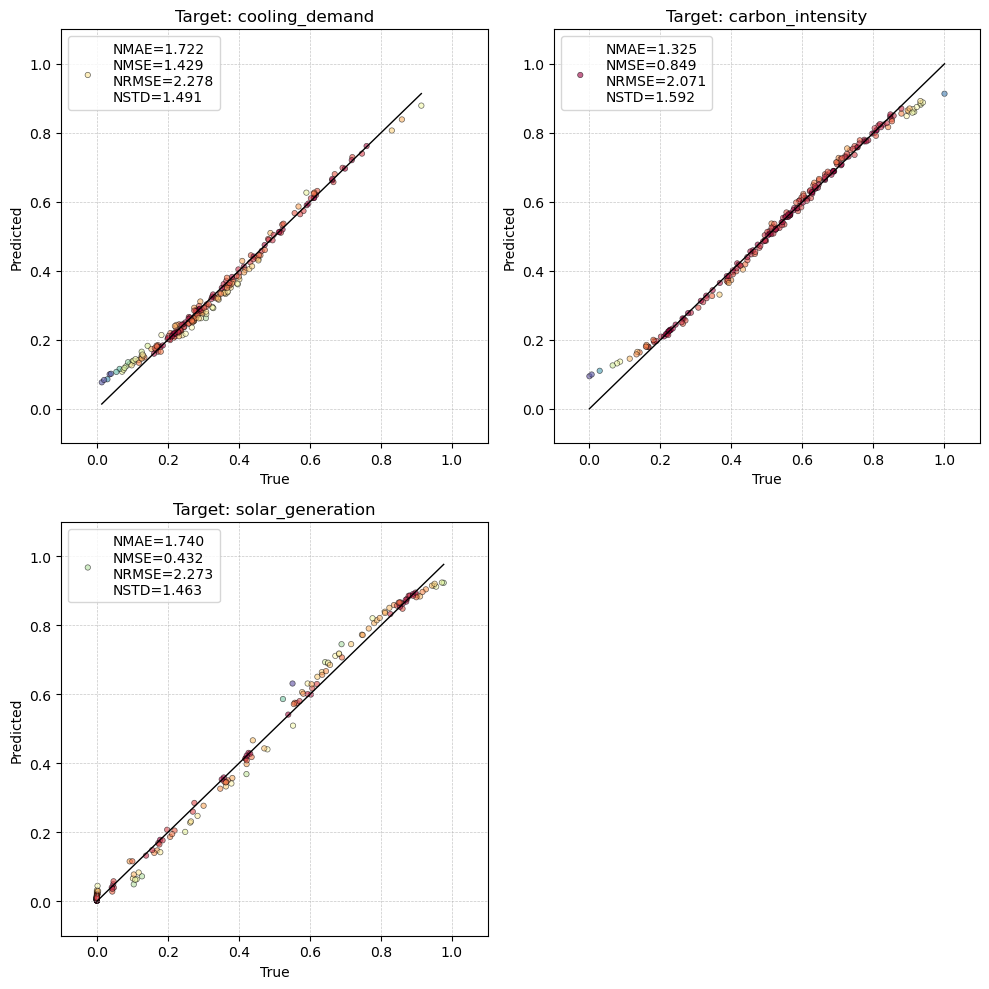

In [10]:
plt.plot_targets(real_3, pred_3, targets, features, percent=True)

In [11]:
real_4, pred_4 = aea.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, batch_size = 64)

Epoch 1/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0744 - mean_absolute_error: 0.2089
Epoch 2/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0308 - mean_absolute_error: 0.1110
Epoch 3/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0977
Epoch 4/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0141 - mean_absolute_error: 0.0797
Epoch 5/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0105 - mean_absolute_error: 0.0675
Epoch 6/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0085 - mean_absolute_error: 0.0596
Epoch 7/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0074 - mean_absolute_error: 0.0559
Epoch 8/3000
12/12 [==============================] - 0s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0533
Epoch 9/3000
12/12 [==============================] - 0s 5ms/step - loss: 0.0062 - mean_absolute_error: 0.0508
E

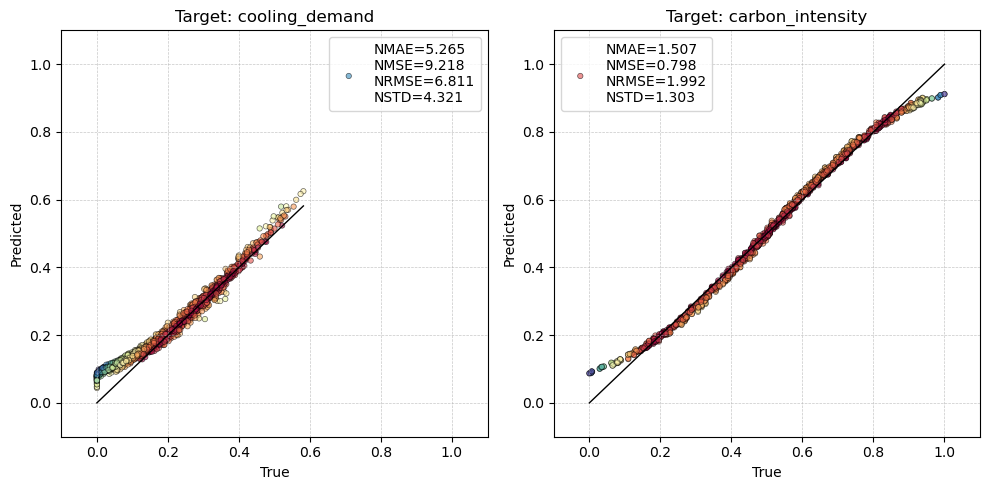

In [12]:
plt.plot_targets(real_4, pred_4, targets[:2], features, percent=True)

### Introducing Non Linear Activation Functions and Model Enhancements

To further improve the reconstruction performance, this section introduces non-linear activation functions (e.g. ReLU, ELU) within the hidden layers of the autoencoder. Additionally, the model configuration is enhanced by experimenting with a different optimizer, adjusting the dimensionality of the latent space and adding the batch normalization procedure after every layer. These changes aim to boost the model’s representation power and optimize its ability to reconstruct complex patterns in the input features.

In [13]:
real_5, pred_5, _ = aer.Autoencoder(dataframe=df, features=features, epochs = 1000, latent_dim = 32, batch_size = 128)

Epoch 1/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1340 - mean_absolute_error: 0.3262
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1216 - mean_absolute_error: 0.3113
Epoch 3/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.1084 - mean_absolute_error: 0.2940
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0945 - mean_absolute_error: 0.2737
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0812 - mean_absolute_error: 0.2517
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0698 - mean_absolute_error: 0.2300
Epoch 7/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0613 - mean_absolute_error: 0.2103
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.0558 - mean_absolute_error: 0.1944
Epoch 9/1000
4/4 [==============================] - 0s 4ms/step - loss: 0.0525 - mean_absolute_error: 0.1823
Epoch 10/1000
4/4 [

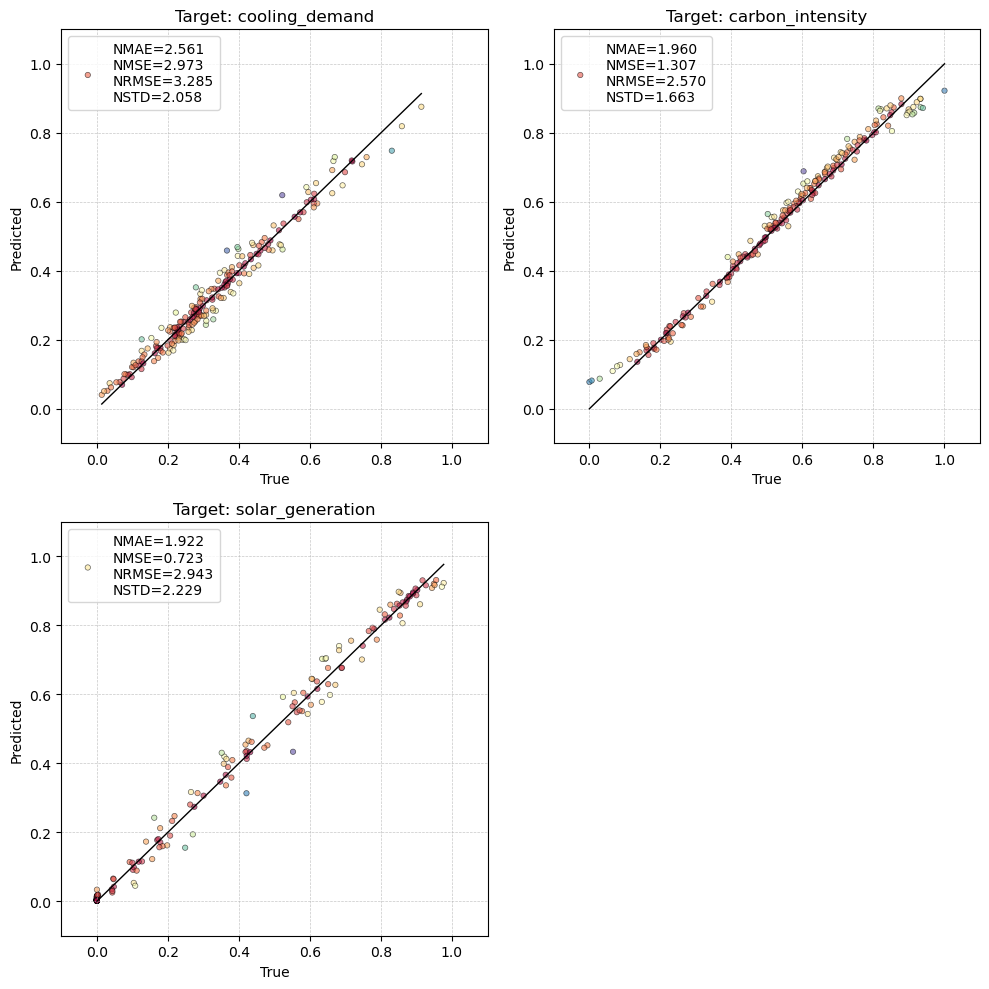

In [14]:
plt.plot_targets(real_5, pred_5, targets, features, percent=True)

In [15]:
real_6, pred_6, model = aer.Autoencoder(train_df=train_df, test_df=test_df, features=features, epochs = 3000, latent_dim = 32, batch_size = 128)
model.save(os.path.join("..", "reports", "models", "autoencoder_generalization.h5"))

Epoch 1/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.1305 - mean_absolute_error: 0.3216
Epoch 2/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.1141 - mean_absolute_error: 0.3018
Epoch 3/3000
6/6 [==============================] - 0s 5ms/step - loss: 0.0956 - mean_absolute_error: 0.2767
Epoch 4/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0772 - mean_absolute_error: 0.2470
Epoch 5/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0631 - mean_absolute_error: 0.2174
Epoch 6/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0544 - mean_absolute_error: 0.1930
Epoch 7/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0495 - mean_absolute_error: 0.1760
Epoch 8/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0454 - mean_absolute_error: 0.1641
Epoch 9/3000
6/6 [==============================] - 0s 4ms/step - loss: 0.0416 - mean_absolute_error: 0.1545
Epoch 10/3000
6/6 [

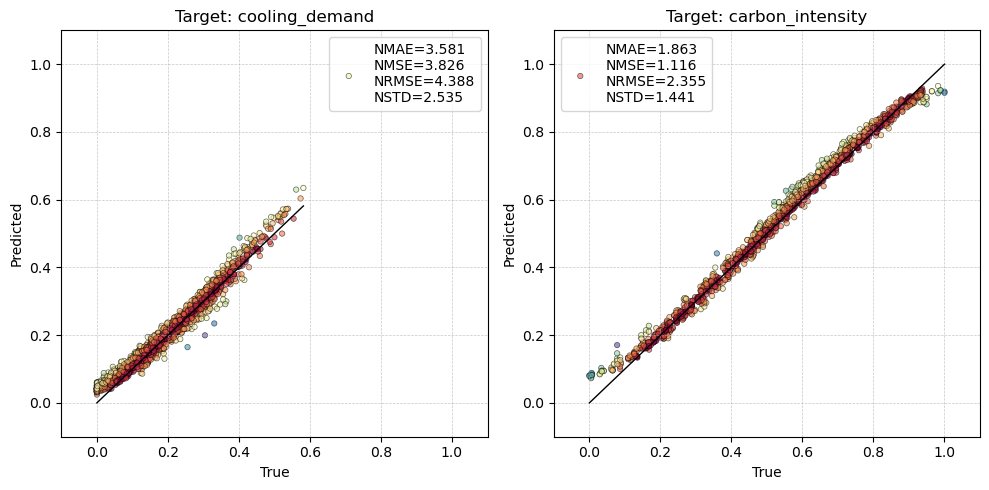

In [16]:
plt.plot_targets(real_6, pred_6, targets[:2], features, percent=True)

### Adding K-fold Cross-validation

#### Tuning
In this phase, the autoencoder is trained and evaluated using K-Fold Cross Validation, a technique that splits the dataset into k subsets (folds). Each fold is used once as a validation set while the remaining k-1 folds are used for training.
The base architecture used for the autoencoder in this phase is the same as the model described in the previous section, allowing the results to be compared effectively.

In [17]:
real_7, pred_7, model = aek.Autoencoder(dataframe=df, features=features, epochs = 200, latent_dim = 64, batch_size = 32, kfold = 10)
model.save(os.path.join("..", "reports", "models", "autoencoder_kfoldtuning.h5"))

Fold 1/10
Epoch 1/200
21/21 [==============================] - 1s 12ms/step - loss: 0.1147 - mean_absolute_error: 0.3014 - val_loss: 0.0801 - val_mean_absolute_error: 0.2495
Epoch 2/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0620 - mean_absolute_error: 0.2104 - val_loss: 0.0537 - val_mean_absolute_error: 0.1773
Epoch 3/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0442 - mean_absolute_error: 0.1593 - val_loss: 0.0414 - val_mean_absolute_error: 0.1474
Epoch 4/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0336 - mean_absolute_error: 0.1357 - val_loss: 0.0341 - val_mean_absolute_error: 0.1306
Epoch 5/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0280 - mean_absolute_error: 0.1208 - val_loss: 0.0290 - val_mean_absolute_error: 0.1176
Epoch 6/200
21/21 [==============================] - 0s 5ms/step - loss: 0.0239 - mean_absolute_error: 0.1095 - val_loss: 0.0253 - val_mean_absolute_error: 0.1095
Epoch 7/200

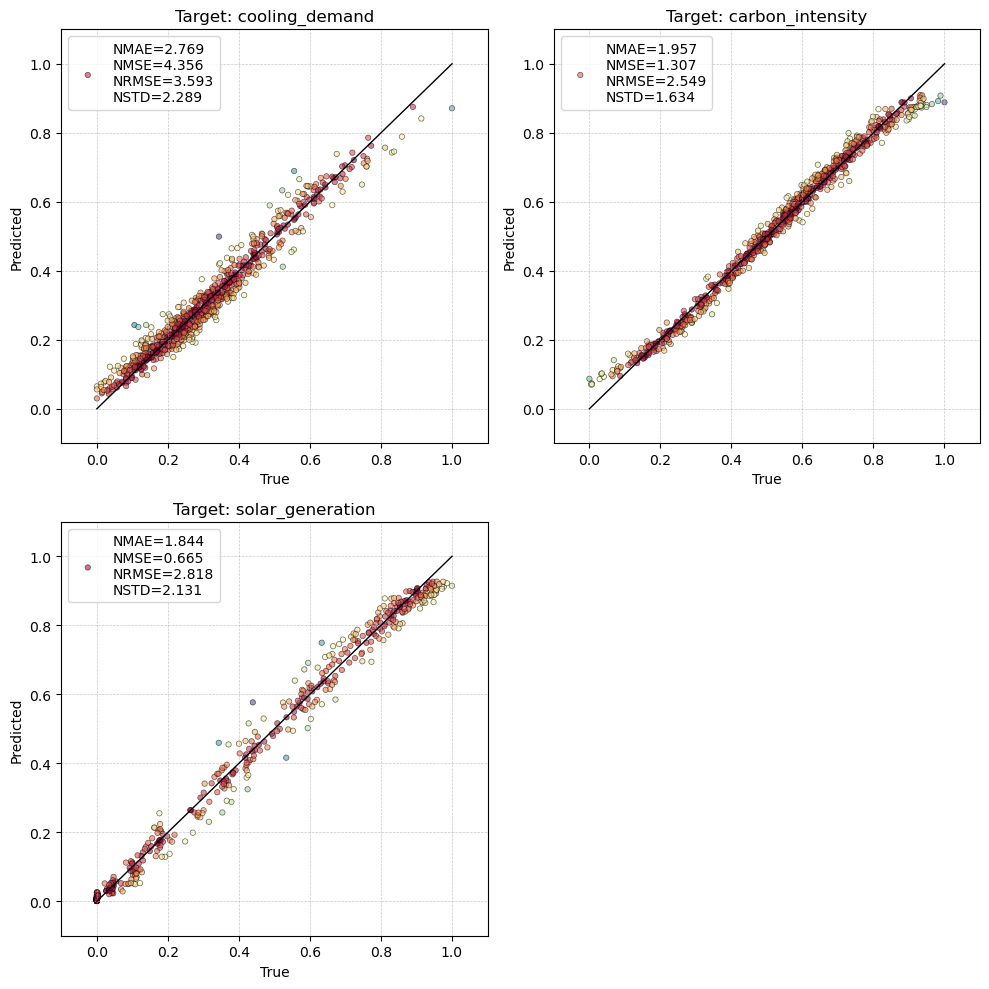

In [18]:
plt.plot_targets(real_7, pred_7, targets, features, percent=True)

#### Final Training
After choosing the best hyperparameters during the tuning phase with K-Fold Cross Validation, the model is trained on the full available dataset.
The model is trained using data from one or more buildings and then tested on a different building that was never used during training.
This method checks how well the model can generalize and perform on new, unseen data with different characteristics. It provides a more realistic and reliable evaluation for real-world situations where the model faces new buildings or environments.

In [19]:
electricity_d = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
df2 = pd.concat([electricity_d, carbon_data, pricing_data, weather_data], axis=1)

In [20]:
real_8, pred_8, model = aek.Autoencoder(dataframe=df2, features=features, epochs = 1000, latent_dim = 64, batch_size = 32)
model.save(os.path.join("..", "reports", "models", "autoencoder_kfoldtrain.h5"))

Epoch 1/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.1310 - mean_absolute_error: 0.3284
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0790 - mean_absolute_error: 0.2488
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0531 - mean_absolute_error: 0.1825
Epoch 4/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0433 - mean_absolute_error: 0.1557
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0355 - mean_absolute_error: 0.1390
Epoch 6/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0318 - mean_absolute_error: 0.1276
Epoch 7/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0289 - mean_absolute_error: 0.1196
Epoch 8/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0259 - mean_absolute_error: 0.1122
Epoch 9/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.0234 - mean_absolute_error: 0.1058
E

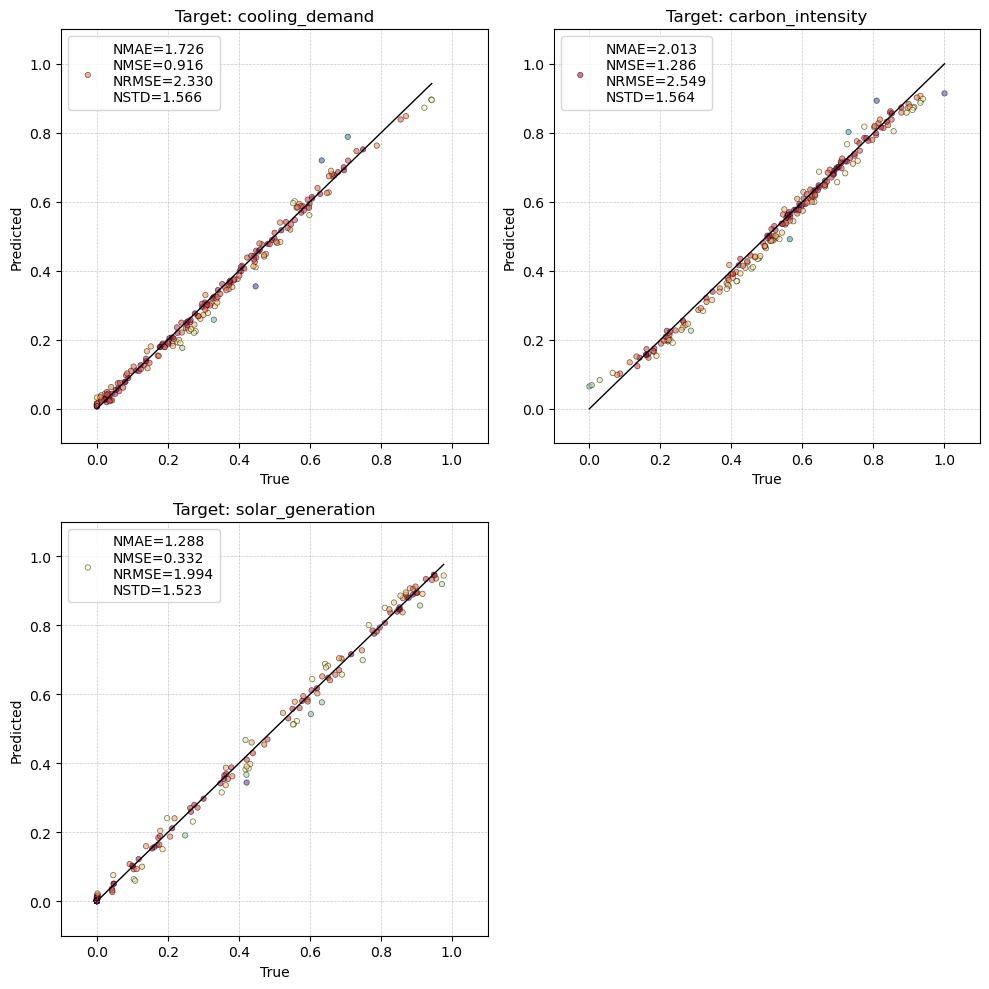

In [21]:
plt.plot_targets(real_8, pred_8, targets, features, percent=True)